## Parte 1:
Primero instalaremos la biblioteca folium y leemos el archivo con pandas. Tal y como se pide replicar en el archivo original, creamos una columna llamada "dpt_code" y "prov_code" (en base a data ya existente) , para luego filtrar los datos solo para mujeres. Después de ello convertimos columna month en formato de número y ordenamos nuestra df por departamento y mes. 

In [14]:
!pip install geopandas
!pip install folium
!pip install mplleaflet

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for mplleaflet: filename=mplleaflet-0.0.5-py3-none-any.whl size=28574 sha256=387808e6612fe82818a2e7716175111460bf8858fe30b4870b99ba38cfcc3af8
  Stored in directory: c:\users\pc14\appdata\local\pip\cache\wheels\19\d8\76\c40290202e76c98889c67d6c21fe5e7057334b088e21ef88ba
Successfully built mplleaflet


In [ ]:
import folium
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from folium import plugins
import mplleaflet
import branca.colormap as cm
from folium.plugins import MiniMap
from branca.colormap import LinearColormap

In [16]:
sex_work = pd.read_stata('C:/Users/nando/OneDrive/Documentos/GitHub/QLAB_Summer_Python/_data/8_trab_sex_20.dta')

sex_work['dpt_code'] = sex_work.cod_ubigeo.str[:2].copy()
sex_work['prov_code'] = sex_work.cod_ubigeo.str[:4].copy()
women_work = sex_work[sex_work.sex == 'Mujer'].copy().reset_index(drop=True)
women_work['month'] = pd.to_datetime(women_work.month, format='%B').dt.strftime('%m').astype(int)
women_work.sort_values(['dpt_code', 'month'], inplace=True)

FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/nando/OneDrive/Documentos/GitHub/QLAB_Summer_Python/_data/8_trab_sex_20.dta'

Obtenemos también el número total de mujeres empleadas por departamento y mes

In [ ]:
dpt_women_work = women_work.groupby(['dpt_code', 'month'], as_index=False)[['empl']].sum().rename(columns={'empl': 'women_empl'})
dpt_women_work

In [ ]:
#Ordenamos con "sort"
dpt_women_work.sort_values(['dpt_code', 'month'], inplace=True)

Obtenemos la media del empleo de las mujeres por departamento

In [ ]:
df2 = dpt_women_work.groupby(['dpt_code'], as_index=False)[['women_empl']].mean()
df2

## Vamos a crear el shapefile, para ello ya debimos haber descargado con anterioridad los archivos shapefile

Lo primero que haremos será cargar los datos geoespaciales para los departamentos, al comienzo seguiremos el procedimiento original del código de la tarea

In [21]:
dpt_shp = gpd.read_file('C:/Users/PC14/Documents/GitHub/QLAB_Summer_Python/_data/INEI_LIMITE_DEPARTAMENTAL/INEI_LIMITE_DEPARTAMENTAL.shp')

DriverError: C:/Users/PC14/Documents/GitHub/QLAB_Summer_Python/_data/INEI_LIMITE_DEPARTAMENTAL/INEI_LIMITE_DEPARTAMENTAL.shp: No such file or directory

Ahora realizamos el merge con el df2 que habíamos definido anteriormente

In [ ]:
df3 = dpt_shp.merge(df2, left_on='CCDD', right_on='dpt_code')
# Creamos el mapa con folium
peru_map = folium.Map(location=[-9.1900, -75.0152], zoom_start=6)

Tenmos que añadir el GeoDataframe al mapa que tenemos, luego el layer control (el cual nos permite controlar qué capas están visibles en nuestro mapa interactivo)

In [ ]:
folium.GeoJson(df3,
               name='geojson',
               style_function=lambda x: {'fillColor': 'red', 'color': 'black', 'weight': 2, 'dashArray': '5, 5'},
               highlight_function=lambda x: {'weight': 3, 'color': 'blue'},
               tooltip=folium.features.GeoJsonTooltip(fields=['women_empl'],
                                                      aliases=['Women Employment'],
                                                      labels=True,
                                                      sticky=True)
               ).add_to(peru_map)

folium.LayerControl().add_to(peru_map)

Ahora convertimos el gráfico de matplotlib a un objeto folium usando plugins, guardamos el mapa interactivo e imprimimos

In [ ]:
fig, ax = plt.subplots(figsize=(20, 20))
df3.plot(ax=ax, column='women_empl', cmap='Reds', linestyle='--', edgecolor='black', legend=True)

folium.plugins.MiniMap().add_to(peru_map)

peru_map.save('peru_map_combined.html')
peru_map

Para la nueva parte del df3 se vuelve a crear el mapa y traspasarlo al folium

In [ ]:
# Creamos el mapa con folium
peru_map1 = folium.Map(location=[-9.1900, -75.0152], zoom_start=6)

folium.GeoJson(df3,
               name='geojson',
               style_function=lambda x: {'fillColor': 'red', 'color': 'black', 'weight': 2, 'dashArray': '5, 5'},
               highlight_function=lambda x: {'weight': 3, 'color': 'blue'},
               tooltip=folium.features.GeoJsonTooltip(fields=['women_empl'],
                                                      aliases=['Women Employment'],
                                                      labels=True,
                                                      sticky=True)
               ).add_to(peru_map1)

folium.LayerControl().add_to(peru_map1)

Finalmente se replica el formato de pandas y se transforma en tipo folium 

In [ ]:
fig, ax = plt.subplots(figsize=(20, 20))
df3.plot( ax = ax, column='women_empl', cmap= 'Reds', figsize=(20, 20), linestyle='--', 
edgecolor='black', legend = True, scheme = "User_Defined", 
         classification_kwds = dict( bins = [ 20000, 40000, 60000, 100000  ] ), 
        legend_kwds = dict(  loc='upper left',
                            bbox_to_anchor=(1.01, 1),
                            fontsize='x-large',
                            title= "Number of Employers", 
                            title_fontsize = 'x-large', 
                            frameon= False )
        )
folium.plugins.MiniMap().add_to(peru_map1)

peru_map.save('peru_map1_combined.html')
peru_map1

Esto viene a ser otra forma de realizar el proceso. Pues para esto se se plantea como si el proceso fuese desde el inicio

In [ ]:
import folium
from folium import Choropleth, GeoJson

# Filtro los datos para CCDD diferente de "15"
filtered_df = df3[df3['CCDD'] != "15"]

# Creo el mapa centrado en la ubicación media de tus datos
centroid_lat = filtered_df.to_crs(epsg='4326').geometry.centroid.y.mean()
centroid_lon = filtered_df.to_crs(epsg='4326').geometry.centroid.x.mean()
m = folium.Map(location=[centroid_lat, centroid_lon], zoom_start=6)
#se le asigna el nombre m al folium para no poner una palabra en cada momento que se menciona de diversas ocaciones

In [ ]:
# Añado la capa de coropleta
Choropleth(
    geo_data=filtered_df,
    data=filtered_df,
    columns=['geometry', 'women_empl'],
    key_on='feature.properties.women_empl',
    fill_color='Reds',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Number of Employers',
    line_color='black',
    line_dash='--',
    edgecolor='black',
    name='Women Employment',
).add_to(m)

# Añado el límite de las áreas geográficas
GeoJson(
    filtered_df,
    name='geojson',
    style_function=lambda x: {
        'color': 'black',
        'weight': 2,
        'dashArray': '5, 5',
    },
).add_to(m)

folium.LayerControl().add_to(m)

# Guardar el mapa
m.save('map_filtered.html')
m

# Parte 2

In [ ]:
pip install folium branca matplotlib

In [ ]:
df4 = sex_work.groupby(['dpt_code', 'month', 'sex'], as_index=False)[['empl']].sum() \
        .pivot(index=['dpt_code', 'month'], columns='sex', values='empl') \
        .reset_index()

In [ ]:
df4

In [ ]:
df4[ 'prop_wom' ] = ( df4.Mujer * 100 / df4.Hombre )

In [19]:
df5 = dpt_shp.merge( df4, left_on = 'CCDD', right_on = 'dpt_code'  )
# Creamos el mapa con folium
peru_map = folium.Map(location=[-9.1900, -75.0152], zoom_start=6)

NameError: name 'dpt_shp' is not defined

In [ ]:
folium.GeoJson(df5,
               name='geojson',
               style_function=lambda x: {'fillColor': 'red', 'color': 'black', 'weight': 2, 'dashArray': '5, 5'},
               highlight_function=lambda x: {'weight': 3, 'color': 'blue'},
               tooltip=folium.features.GeoJsonTooltip(fields=['women_empl'],
                                                      aliases=['Women Employment'],
                                                      labels=True,
                                                      sticky=True)
               ).add_to(peru_map)

folium.LayerControl().add_to(peru_map)

NameError: name 'df5' is not defined

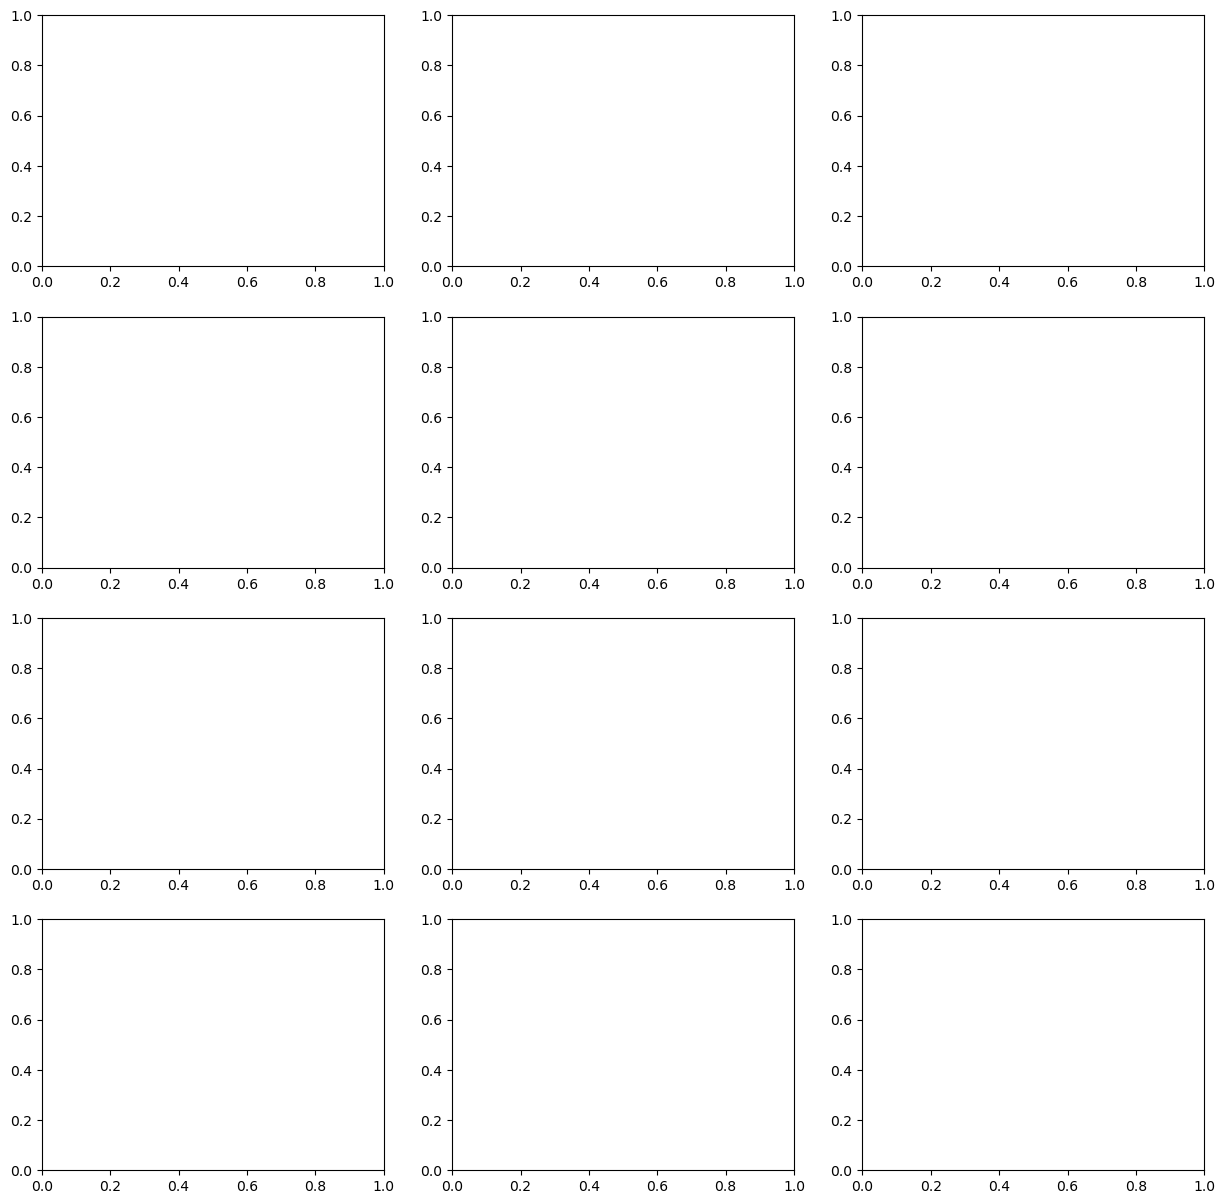

In [18]:
def create_folium_map(df_month, month):
    df_json = df_month.to_json()
    # Create the Map instance
    m = folium.Map(location=[-9.1900, -75.0152], zoom_start=6)
    colormap = linear.YlOrRd_09.scale(df_month['prop_wom'].min(), df_month['prop_wom'].max())
    folium.GeoJson(
        df_json,
        name=f'Women Employment - {month}',
        style_function=lambda feature: {
            'fillColor': colormap(feature['properties']['prop_wom']),
            'color': 'black',
            'weight': 2,
            'dashArray': '5, 5'
        }
    ).add_to(m)

    colormap.add_to(m)
    html_file = f"map_{month}.html"
    m.save(html_file)
    return html_file

# Crear subgráficos de Matplotlib
fig, axis = plt.subplots(nrows=4, ncols=3, figsize=(15, 15))

idx = 0
html_files = []  # Almacena nombres de archivos HTML

for i in range(4):
    for j in range(3):
        ax = axis[i, j]

        if idx < len(df5['month'].unique()):
            month = df5['month'].unique()[idx]
            df6 = df5[df5['month'] == month]

            html_file = create_folium_map(df6, month)
            html_files.append(html_file)  # Almacena nombres de archivos HTML

            ax.set_title(month)

        idx += 1

# Imprime los enlaces HTML
for file in html_files:
    print(file)

## Parte 3

In [ ]:
from textwrap import wrap

In [ ]:
# Inverting colour map
cmap = plt.cm.OrRd

Se repite uno de los procesos realizados en parte 1

In [ ]:
# Creamos el mapa con folium
peru_map2 = folium.Map(location=[-9.1900, -75.0152], zoom_start=6)

folium.GeoJson(df6,
               name='geojson',
               style_function=lambda x: {'fillColor': 'red', 'color': 'black', 'weight': 2, 'dashArray': '5, 5'},
               highlight_function=lambda x: {'weight': 3, 'color': 'blue'},
               tooltip=folium.features.GeoJsonTooltip(fields=['women_empl'],
                                                      aliases=['Women Employment'],
                                                      labels=True,
                                                      sticky=True)
               ).add_to(peru_map1)

folium.LayerControl().add_to(peru_map1)

Finalmente se utiliza una forma de resolver esta parte 

NameError: name 'df6' is not defined

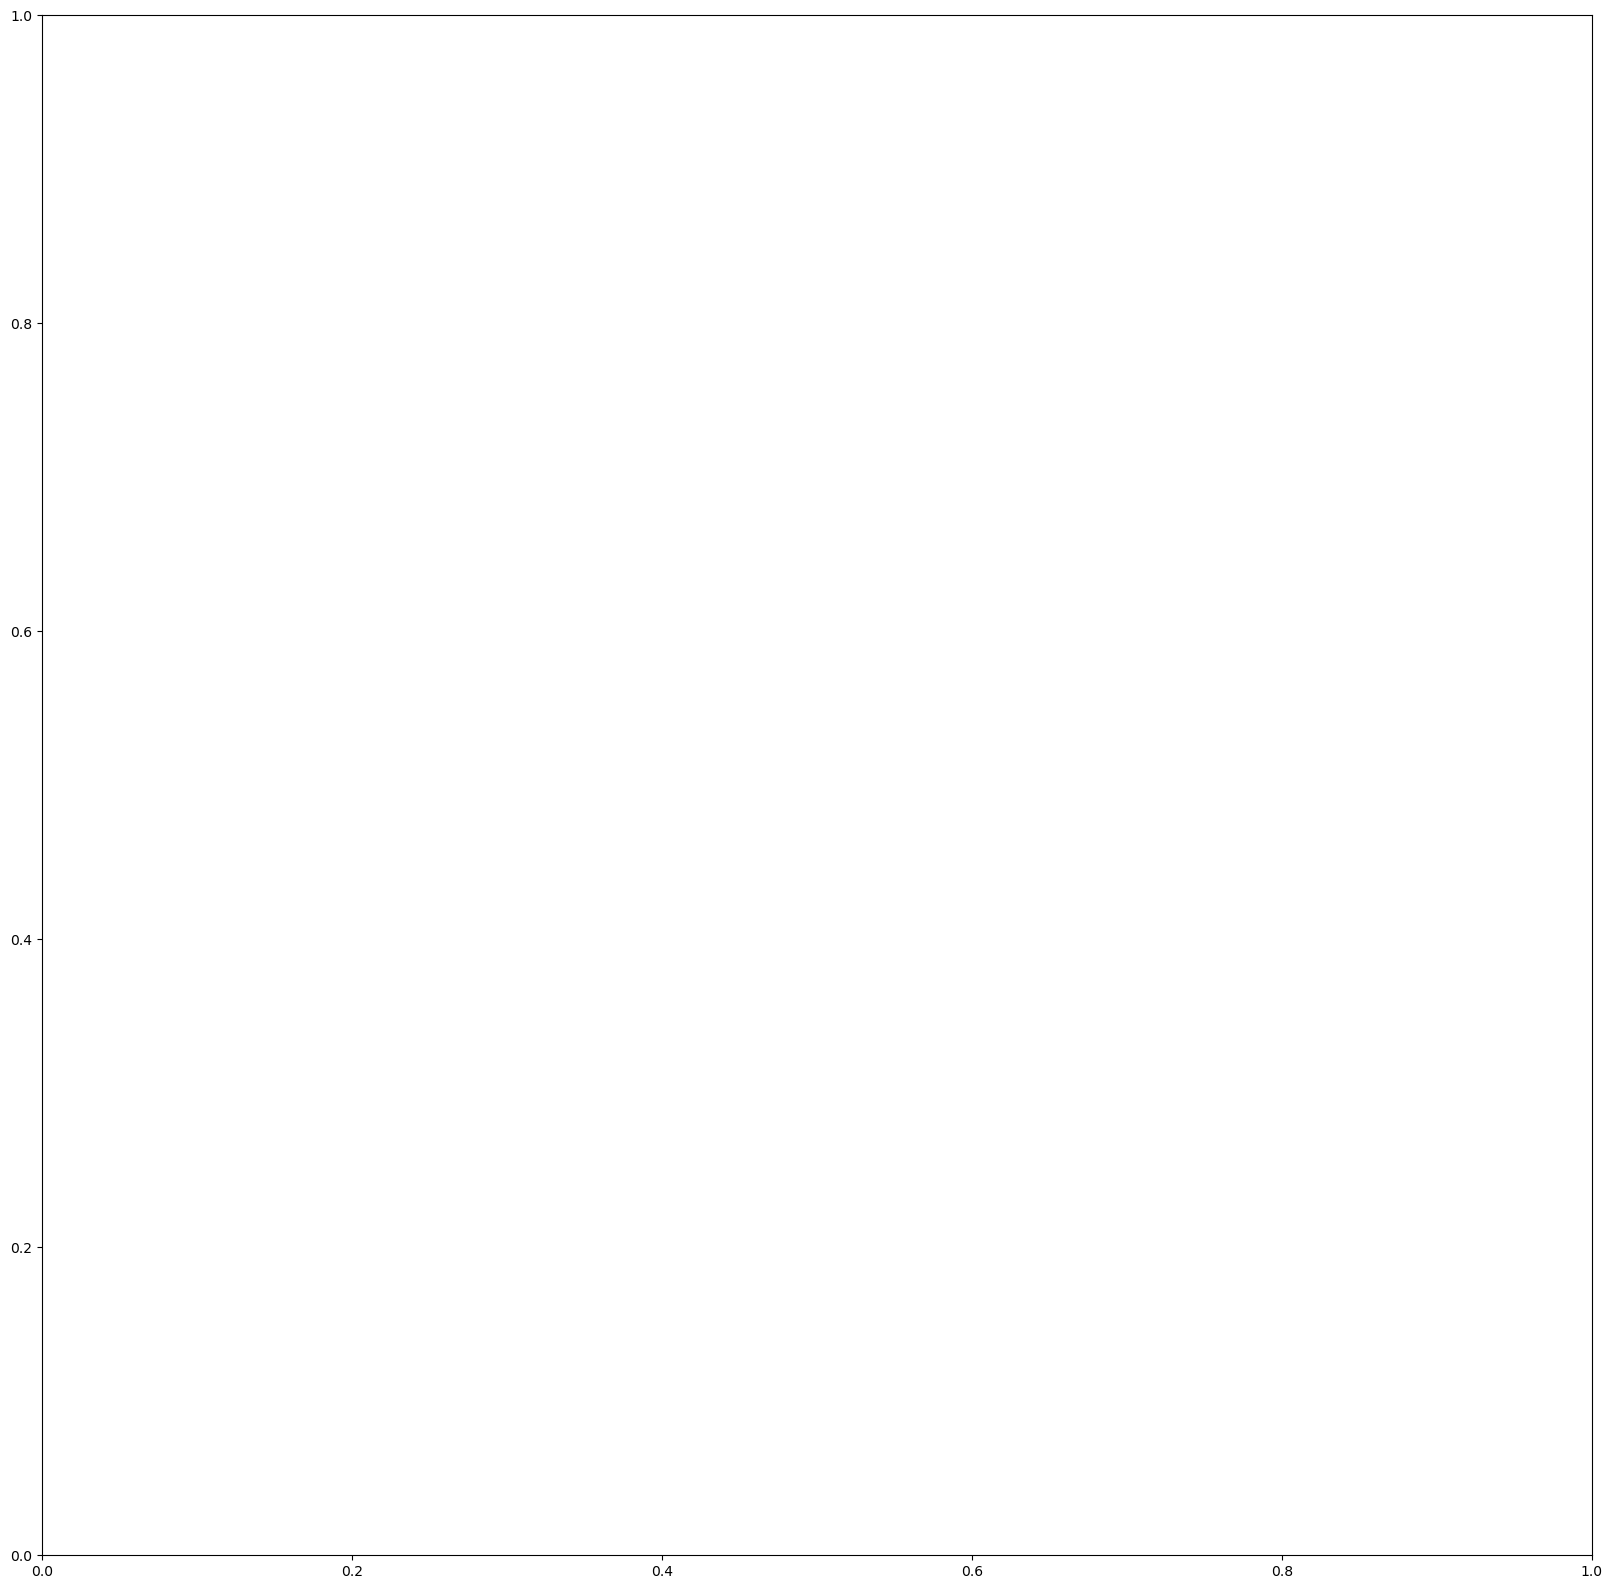

In [17]:
fig, ax = plt.subplots(figsize=(20, 20))
df6.plot( ax = ax, 
        column='prop_wom', 
         cmap= cmap, 
         figsize=(20, 20), 
         linestyle='--',
         edgecolor='black', 
         legend = True,  
         scheme = "User_Defined", 
         classification_kwds = dict( bins = [ 20, 30, 40, 50,  100 ] ), 
         legend_kwds=dict(  loc='upper left',
                            bbox_to_anchor=(1.01, 1),
                            fontsize='x-large',
                            title= "Women Proportion", 
                            title_fontsize = 'x-large', 
                            frameon= False )
        )
folium.plugins.MiniMap().add_to(peru_map2)

peru_map.save('peru_map2_combined.html')
peru_map2


# Parte 4

In [ ]:
!pip install geopandas
!pip install folium
!pip install mplleaflet
import folium
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from folium import plugins
import mplleaflet
import branca.colormap as cm
from folium.plugins import MiniMap
from branca.colormap import LinearColormap